In [1]:
%matplotlib inline
import numpy as np
import openface 
import matplotlib.pyplot as plt
from matplotlib import cm
import time
from cv2 import resize
import cv2
import dlib
import os

In [2]:
import mxnet as mx
os.chdir('/home/mckc/Downloads/FaceNet/')
from mtcnn_detector import MtcnnDetector
mxnet_detector = MtcnnDetector(model_folder='model', ctx=mx.cpu(0), num_worker = 1 , accurate_landmark = False)

In [3]:
predictor_model = "/home/mckc/Downloads/shape_predictor_68_face_landmarks.dat"

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_model)

In [27]:
align = openface.AlignDlib('/home/mckc/Downloads/shape_predictor_68_face_landmarks.dat')
net = openface.TorchNeuralNet('/home/mckc/Downloads/Pretrained models/openface.nn4.small2.v1.t7', imgDim=96,cuda=True)

In [28]:
face_cascade = cv2.CascadeClassifier('/home/mckc/Downloads/opencv-2.4.13/data/lbpcascades/lbpcascade_frontalface.xml')

In [29]:
# The code here is adapted from the following 2 sources.
# https://github.com/cmusatyalab/openface/blob/master/openface/align_dlib.py
# https://gist.github.com/ageitgey/82d0ea0fdb56dc93cb9b716e7ceb364b

TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)

OUTER_EYES_AND_NOSE = [36, 45, 33]
np_landmark_indices = np.array(OUTER_EYES_AND_NOSE)

# The required pre-trained face detection model can be downloaded here:
# http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor_model = "/home/mckc/Downloads/shape_predictor_68_face_landmarks.dat"

# Initialise the predictor and detector from dlib
predictor = dlib.shape_predictor(predictor_model)
detector = dlib.get_frontal_face_detector()


def get_aligned_faces(image, img_dim=96):
    """
    Get a list of faces found in the given image,
    if no face was found, returns an empty list
    """
    detected_faces = detector(image, 1)
    aligned_faces = []
    
    for i, face_rect in enumerate(detected_faces):
#         print("Face #{} found at Left: {} Top: {} Right: {} Bottom: {}"
#               .format(i, face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()))
        landmarks = predictor(image, face_rect)

        np_landmarks = np.float32(list(map(lambda p: (p.x, p.y), landmarks.parts())))
        
        H = cv2.getAffineTransform(np_landmarks[np_landmark_indices],
                                   img_dim * MINMAX_TEMPLATE[np_landmark_indices])
    
        thumbnail = cv2.warpAffine(image, H, (img_dim, img_dim))
        aligned_faces.append(thumbnail)
        
    return aligned_faces

In [30]:
from PIL import Image
a = np.array(Image.open('/home/mckc/Downloads/11886124_1065378516827264_4188336381478897919_o.jpg'))
#a = resize(cv2.cvtColor(a, cv2.COLOR_BGR2GRAY),(750,1100))
a.shape

(1100, 1100, 3)

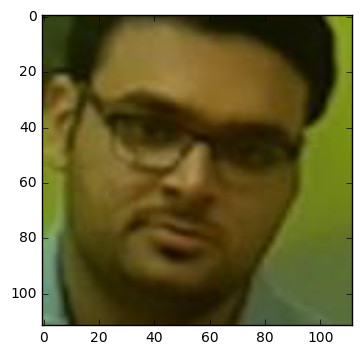

In [31]:
from PIL import Image
img = np.array(Image.open('/home/mckc/cleaned/Abhinav /18_2406.jpg'))
plt.imshow(img)

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 111 ms


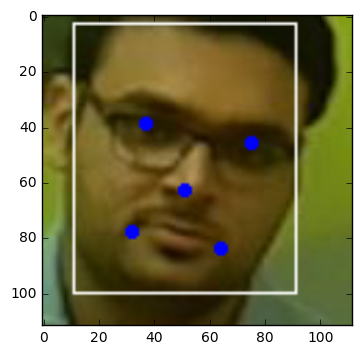

In [32]:
%%time
results = mxnet_detector.detect_face(img)
if results is not None:

    total_boxes = results[0]
    points = results[1]

    draw = img.copy()
    for b in total_boxes:
        cv2.rectangle(draw, (int(b[0]), int(b[1])), (int(b[2]), int(b[3])), (255, 255, 255))

    for p in points:
        for i in range(5):
            cv2.circle(draw, (p[i], p[i + 5]), 1, (0, 0, 255), 2)

plt.imshow(draw)

CPU times: user 56 ms, sys: 24 ms, total: 80 ms
Wall time: 42 ms


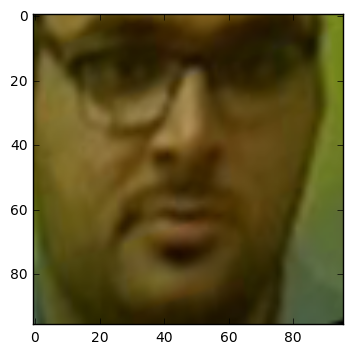

In [33]:
%%time
aligned = np.array(get_aligned_faces(img))
if len(aligned)>0:
    plt.imshow(aligned[0])

In [34]:
%%time
faces = face_cascade.detectMultiScale(img,scaleFactor=1.1,minNeighbors=5,minSize=(90, 90))
print type(faces)
if faces.shape[0]>0:
    x,y,w,h =faces[0]
    #rect=dlib.rectangle.__init__('g',(x,y,x+w,y+h))

<type 'numpy.ndarray'>
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.05 ms


CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 41.6 ms


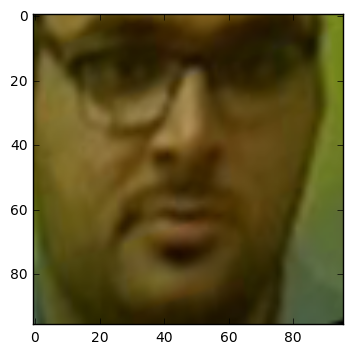

In [35]:
%%time
c  = align.getLargestFaceBoundingBox(img)
alignedFace = align.align(96, img, c,landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)
plt.imshow(alignedFace)

In [38]:
net.forward(img)

Exception: 


OpenFace: `openface_server.lua` subprocess has died.

+ Is the Torch command `th` on your PATH? Check with `which th`.

+ If `th` is on your PATH, try running `./util/profile-network.lua`
  to see if Torch can correctly load and run the network.

  + If this gives illegal instruction errors, see the section on
    this in our FAQ at http://cmusatyalab.github.io/openface/faq/

  + In Docker, use a Bash login shell or source
     /root/torch/install/bin/torch-activate for the Torch environment.

+ See this GitHub issue if you are running on a non-64-bit machine:
  https://github.com/cmusatyalab/openface/issues/42

+ Advanced Users: If you think this problem is caused by
running Lua as a subprocess, Vitalius Parubochyi has created
a version of this that uses https://github.com/imodpasteur/lutorpy.
This file is available at <openface>/openface/torch_neural_net.lutorpy.py
and our mailing list discussion on this can be found at:
https://groups.google.com/forum/#!topic/cmu-openface/Jj68LJBdN-Y

+ Please post further issues to our mailing list at
  https://groups.google.com/forum/#!forum/cmu-openface

Diagnostic information:

cmd: ['/usr/bin/env', 'th', '/home/mckc/anaconda/lib/python2.7/site-packages/openface/openface_server.lua', '-model', '/home/mckc/Downloads/Pretrained models/openface.nn4.small2.v1.t7', '-imgDim', '96', '-cuda']

============

stdout: 
